In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
import sys
import os
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Content')
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Content')

Mounted at /content/gdrive


# Import libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE
import statsmodels.api as sm_api
from time import time
import seaborn as sns
%matplotlib inline

In [4]:
# set random seed
RANDOM_SEED = np.random.seed(0)

We will be using the statsmodels library for the creation of ARIMA/SARIMA | ARIMAX/SARIMAX models.

np.random.seed() sets the seed to ensure our models fit itself with consistent behavior.

# Load dataset

In [7]:
dataset = pd.read_csv('weather_cleaned.csv')
df = dataset[(dataset['location'] == 'Kasetsart University')].drop(columns=['id'])
df = df[df['ts'] <= '2025-04-09 19:00:00']
df

,ts,location,wind_sp,wind_deg,pressure,temperature,humidity,cloud_per,rain_amt,weather
0,2025-03-21 22:00:00,Kasetsart University,2.57,3,1014,27.67,46,20,0.0,few clouds
1,2025-03-21 22:30:00,Kasetsart University,4.12,4,1014,29.32,47,20,0.0,few clouds
2,2025-03-21 23:00:00,Kasetsart University,4.12,4,1014,28.33,48,20,0.0,few clouds
3,2025-03-21 23:30:00,Kasetsart University,3.60,4,1014,27.85,50,20,0.0,few clouds
4,2025-03-22 00:00:00,Kasetsart University,4.12,4,1014,27.38,52,20,0.0,few clouds
...,...,...,...,...,...,...,...,...,...,...
1579,2025-04-09 17:00:00,Kasetsart University,4.63,5,1006,35.00,52,20,0.0,few clouds
1581,2025-04-09 17:30:00,Kasetsart University,4.63,5,1006,34.84,52,20,0.0,few clouds
1583,2025-04-09 18:00:00,Kasetsart University,5.14,5,1006,33.40,53,20,0.0,few clouds
1585,2025-04-09 18:30:00,Kasetsart University,5.66,6,1007,33.20,56,20,0.0,few clouds


An example dataset, This dataset contains weather data collected from 2025-3-21 to 2025-4-9 in intervals of 30 mins.

In order to create a model to predict weather conditions you will need to perform Exploratory Data analysis

# EDA

First we visualize, the data for the attribute we want to predict. For this example we will be focusing primarily on predicting humidity.

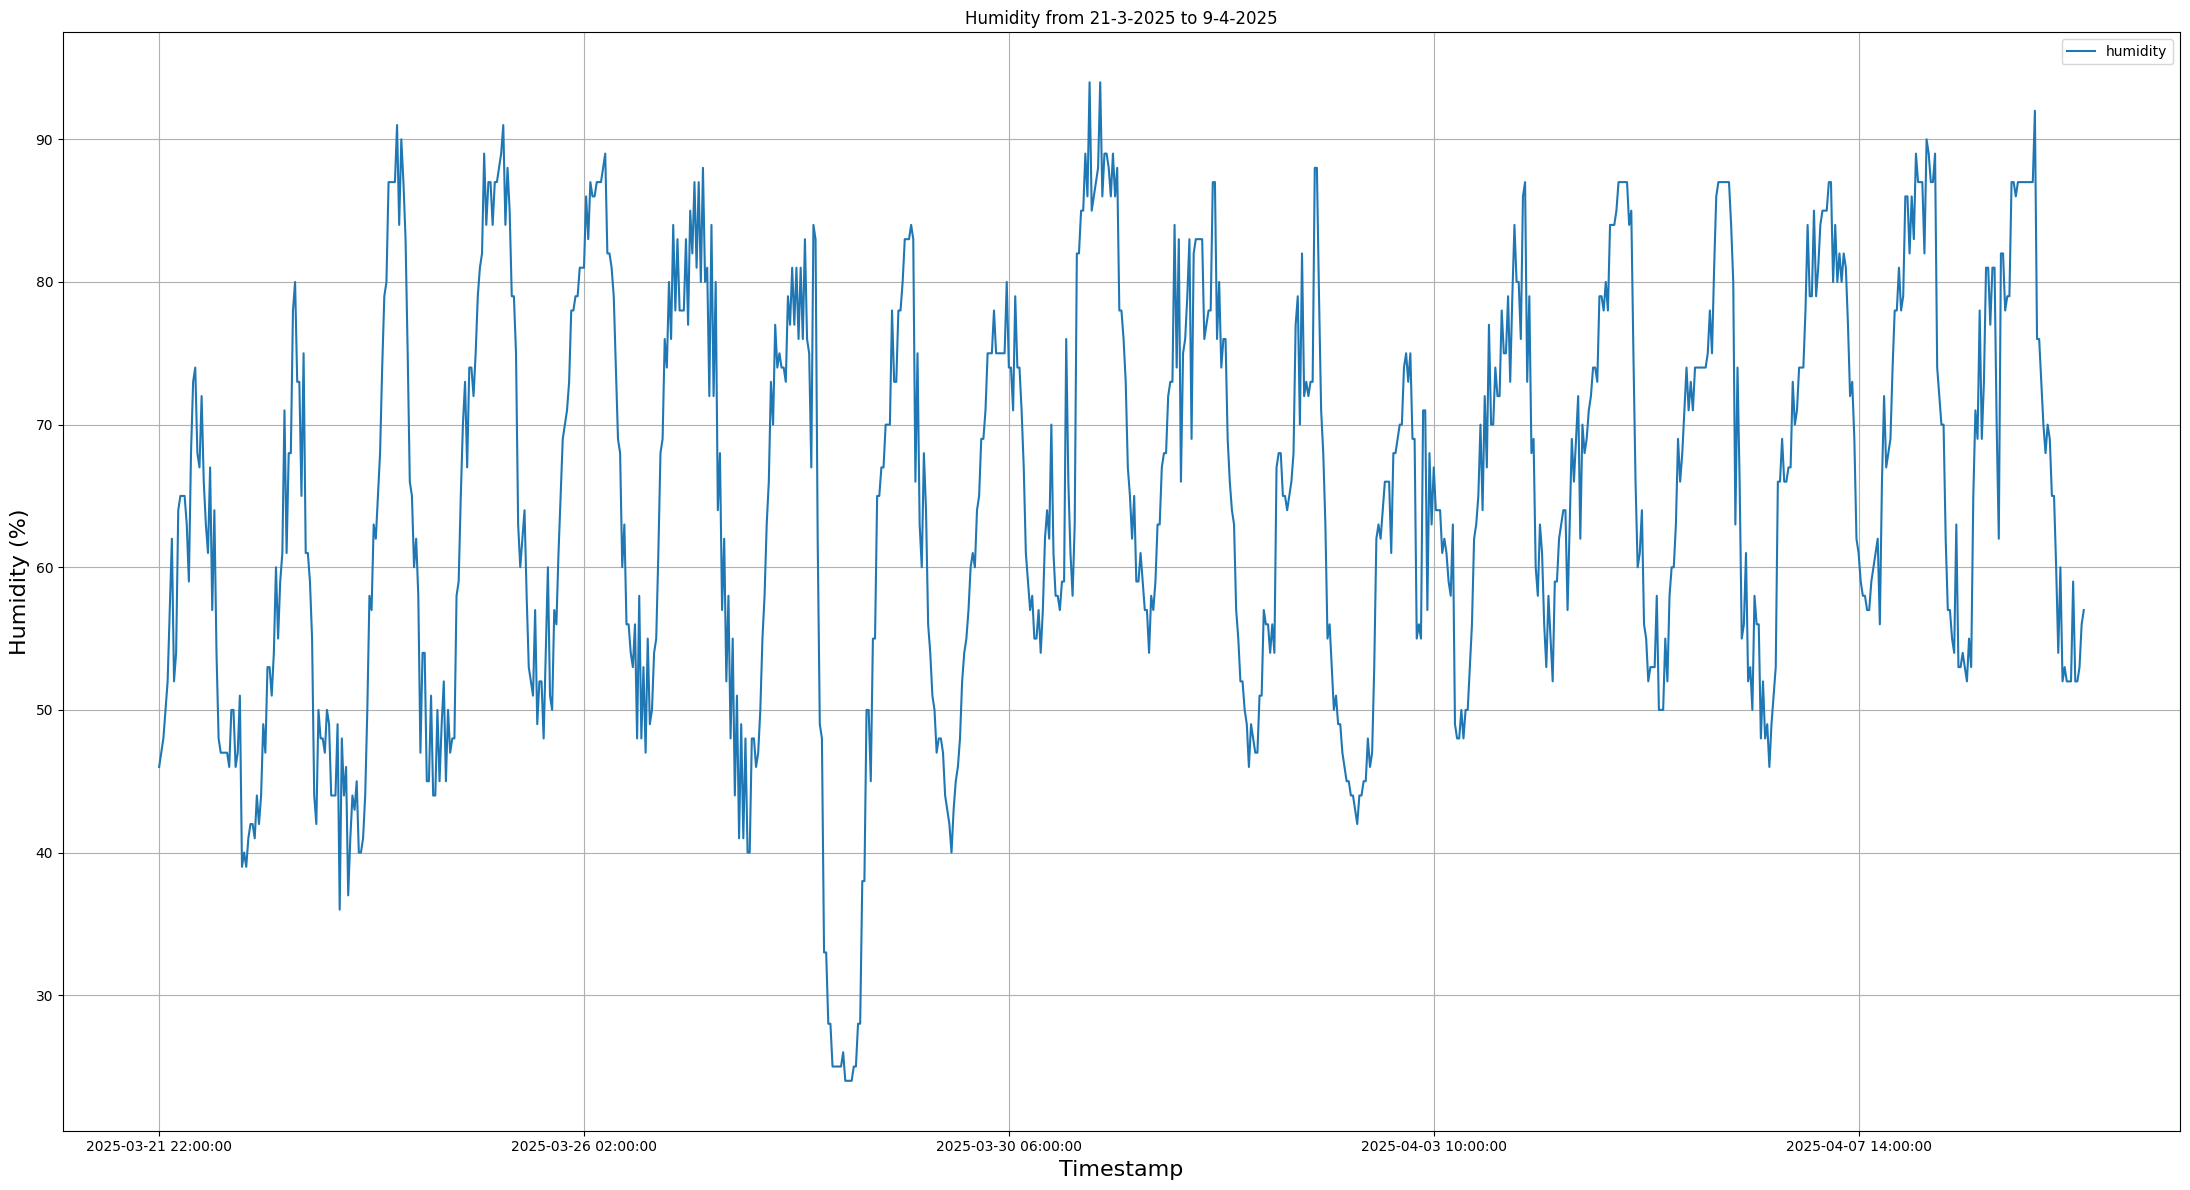

In [9]:
# plot humidity
df.plot(x='ts', y='humidity', figsize=(22, 12), title='Humidity from 21-3-2025 to 9-4-2025')
plt.ylabel('Humidity (%)', fontsize=16)
plt.xlabel('Timestamp', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

From the plot, we can see that humidity fluctuates on a daily basis.

Each point is roughly 4 days appart and we can see that there are roughly 4 spikes between each point. There also appears to be a larger trend to the data but due to the limited timeframe this cannot be captured.

## Augmented dickeyfuller test

The Augmented dickeyfuller test is used to test whether the data is stationary or not.

The Integrated part (d in (p,d,q)) in ARIMA|SARIMA models rely on this test to determine its value.

The order of d is equivalent to the amount of times differencing is performed until the data is stationary. pandas dataframes and series have a .diff() method which can be used to find the first order differenced values.

ref(s):
- https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
- https://pandas.pydata.org/docs/reference/api/pandas.Series.diff.html

In [15]:
# check for stationality
result = adfuller(df['humidity'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
      print("Stationary data")
else:
      print("Non-stationary data")

ADF Statistic: -6.732111
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Stationary data


Since the humidity data is stationary, no need to difference the data

In this case the order of the model should be within (p, 0, q)

In [11]:
# check for stationality
result = adfuller(df['temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
      print("Stationary data")
else:
      print("Non-stationary data")

ADF Statistic: -11.011597
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Stationary data


temperature is also stationary

In [12]:
# check for stationality
result = adfuller(df['pressure'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
      print("Stationary data")
else:
      print("Non-stationary data")

ADF Statistic: -2.935398
p-value: 0.041384
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Stationary data


Pressure is also stationary

## ACF and PACF plots

ACF and PACF plots are used to check various things for ARIMA | SARIMA model creation.

- The AFC plot is used to calculate the q parameter in ARIMA (p, d, q)
- The PACF plot is used to calculate the p parameter in ARIMA (p, d, q)

A quick reference for ACF and PACF plots

| Plot | Condition to model with ARIMA      | Condition to model with AR         | Condition to model with MA         |
|------|------------------------------------|------------------------------------|------------------------------------|
| ACF  | Geometric decay (trends towards 0) | Geometric decay (trends towards 0) | Cut off after x lag                |
| PACF | Geometric decay (trends towards 0) | Cut off after x lag                | Geometric decay (trends towards 0) |

Notes:
- A Geometric decay is a graph which slowly converges to 0.
- A cut off is defined as a lag at x where the value of lag x+1 is significantly different than the value at lag x+1
- Fitting an ARIMA model will require some trial and error. You may need to plot multiple graphs and try different orders of (p,d,q)

ref(s):
- https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf#Examples
- https://otexts.com/fpp2/seasonal-arima.html
- https://online.stat.psu.edu/stat510/lesson/3/3.1

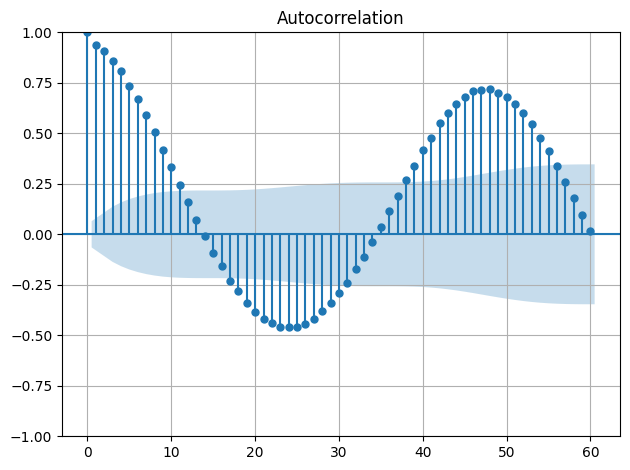

In [17]:
plot_acf(df['humidity'], lags=60);
plt.grid(True)
plt.tight_layout()
plt.show()

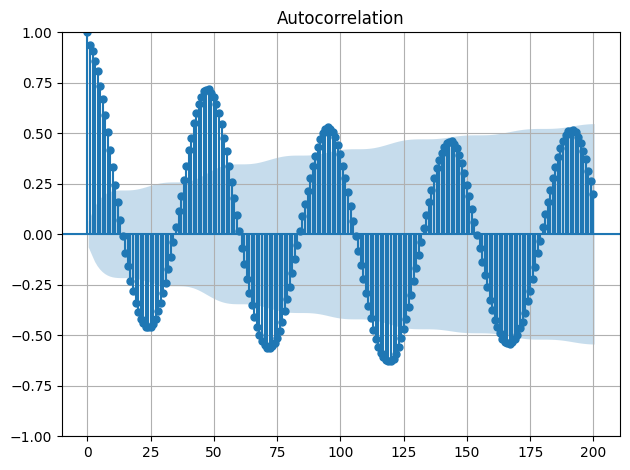

In [16]:
# ACF plot

plot_acf(df['humidity'], lags=200);
plt.grid(True)
plt.tight_layout()
plt.show()

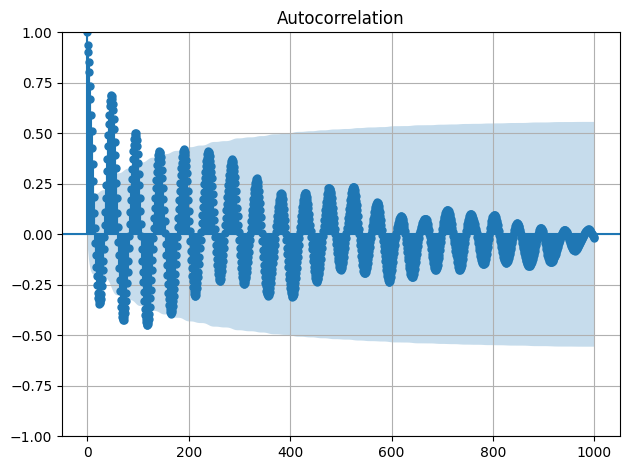

In [ ]:
# ACF plot

plot_acf(df['humidity'], lags=1000);
plt.grid(True)
plt.tight_layout()
plt.show()

From the ACF plot, the plot resembles a Sinusoidal wave and is trending towards 0.

This wave pattern suggests a seasonality component to the data.

Using the ACF plot with lags=1000, we can see that there are 2 "waves" with spikes significantly greater than the "shaded" area (also known as the confidence interval) this suggests that the order of q should be 2.

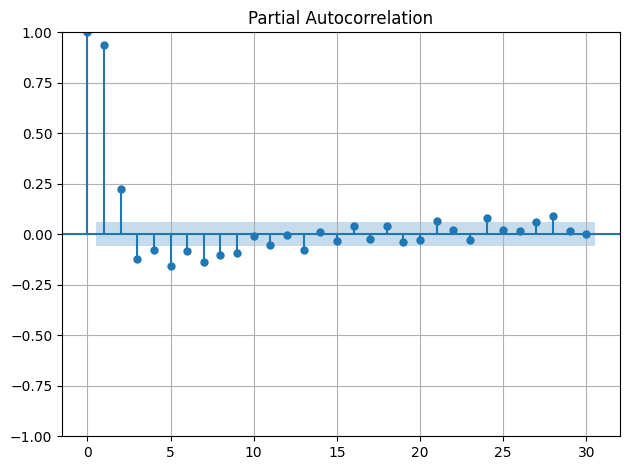

In [ ]:
# PACF plot

plot_pacf(df['humidity'], lags=30);
plt.grid(True)
plt.tight_layout()
plt.show()

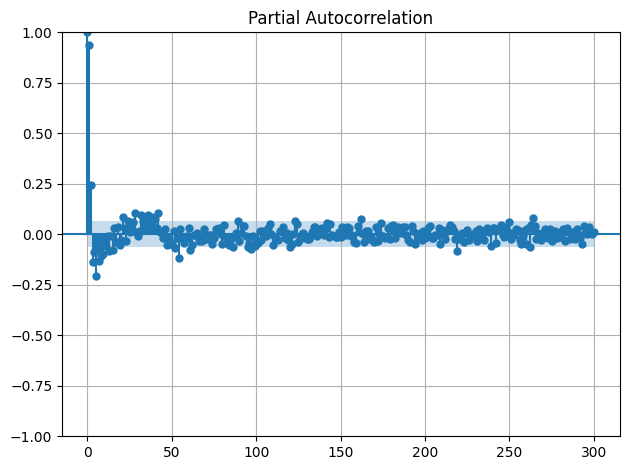

In [18]:
# PACF plot

plot_pacf(df['humidity'], lags=300);
plt.grid(True)
plt.tight_layout()
plt.show()

The PACF plot has 2 significant spikes at lags 1 and 2. and is generally trending towards 0.

This suggest an order of p should be 2.

In conclusion from the Augmented Dickyfuller test and our ACF and PACF plots, our ARIMA model should be ARIMA(2, 0, 2).

## Checking seasonality


The seasonality component is represented as (P,D,Q,s) in a SARIMAX model.

P, D, Q values represent the same parts as p, d, q in ARIMA however, s is periodicy of the dataset.

<br>

In general the initial (P,D,Q) values are equal to the (p,d,q) values in the ARIMA section.

(P, D, Q) values can be fined tuned by looking at residuals created from the fitted SARIMA(p,d,q)(P,D,Q, s)

For the purposes of this guide I will not be fine tuning the seasonal component.

From our ACF plot, the plot suggest that the data contains seasonality.

The periodicy can be interpreted with domain knowledge:

(using known feautures of the data, example: this dataset records data at 30 mins interval each day. Each day contains 24 hours so the seasonality should be 24 or 48)

Or by using Seasonal-Trend decomposition. The statsmodels library has a seasonal_decompose() function which can be used to plot the decomposition.

ref(s):
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

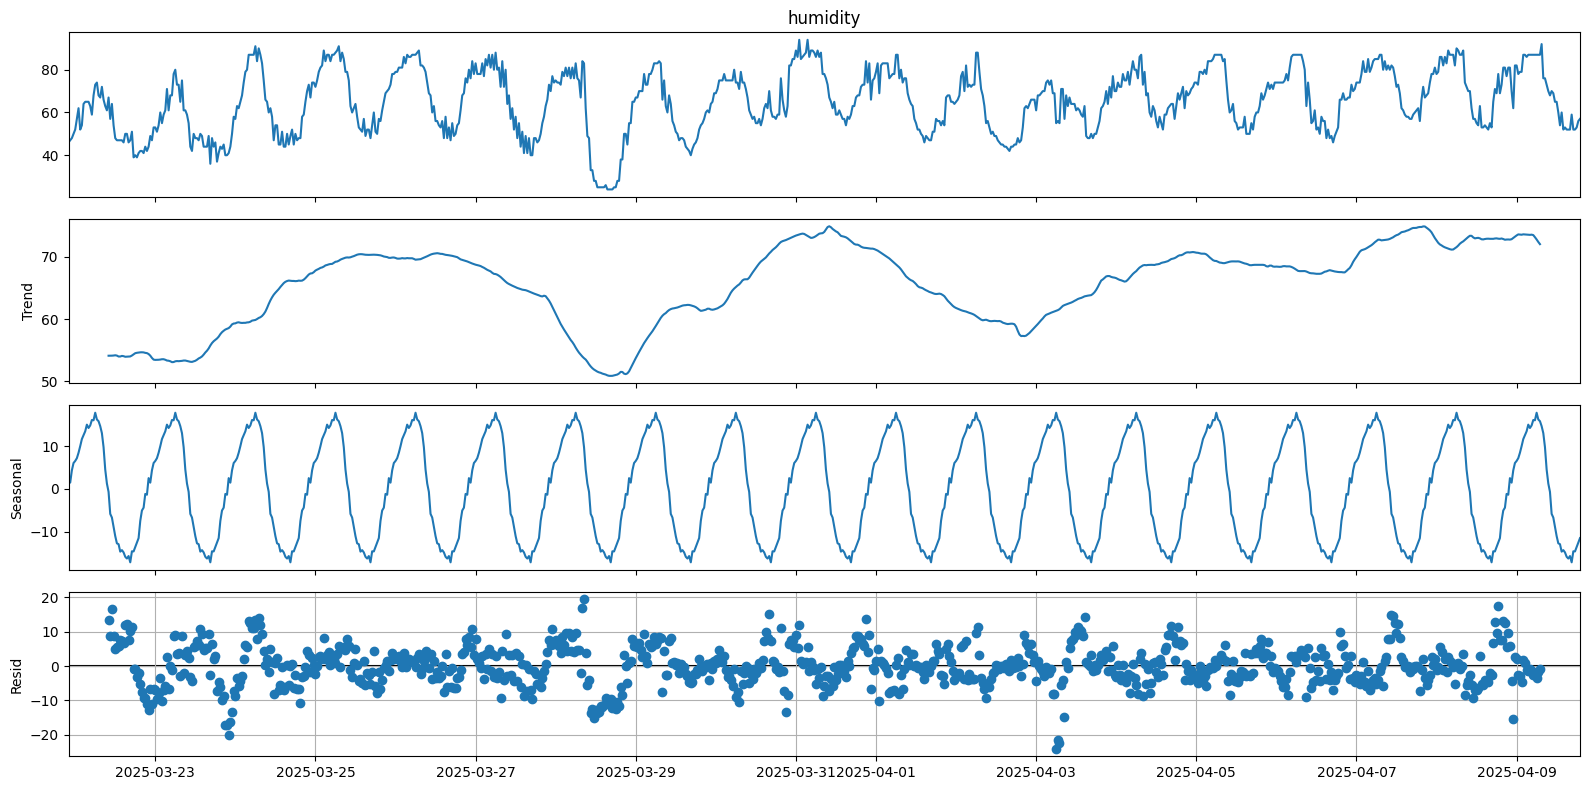

In [24]:
df['ts'] = pd.to_datetime(df['ts'])
result = seasonal_decompose(df.set_index('ts')['humidity'], model='additive', period=48)
fig = result.plot()
fig.set_size_inches(16, 8)
plt.grid(True)
plt.tight_layout()
plt.show()

From the plot, a 24 seasonal pattern is visible (counting the waves).

## Analysis for different features

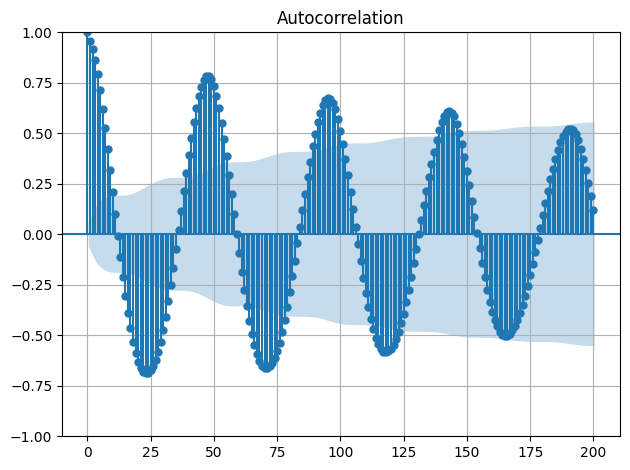

In [ ]:
# ACF plot

plot_acf(df['temperature'], lags=200);
plt.grid(True)
plt.tight_layout()
plt.show()

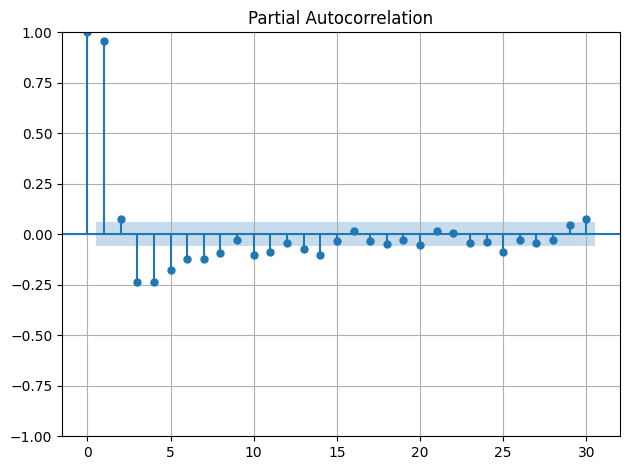

In [ ]:
# PACF plot

plot_pacf(df['temperature'], lags=30);
plt.grid(True)
plt.tight_layout()
plt.show()

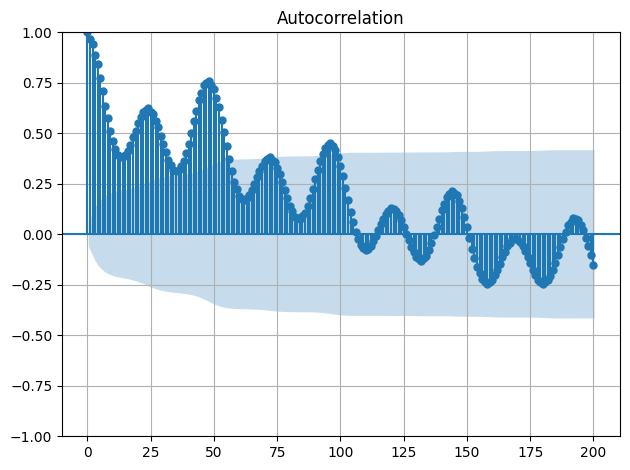

In [ ]:
# ACF plot

plot_acf(df['pressure'], lags=200);
plt.grid(True)
plt.tight_layout()
plt.show()

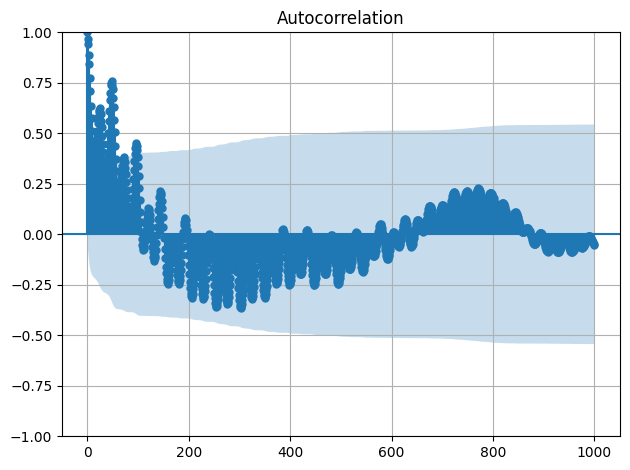

In [ ]:
# ACF plot

plot_acf(df['pressure'], lags=1000);
plt.grid(True)
plt.tight_layout()
plt.show()

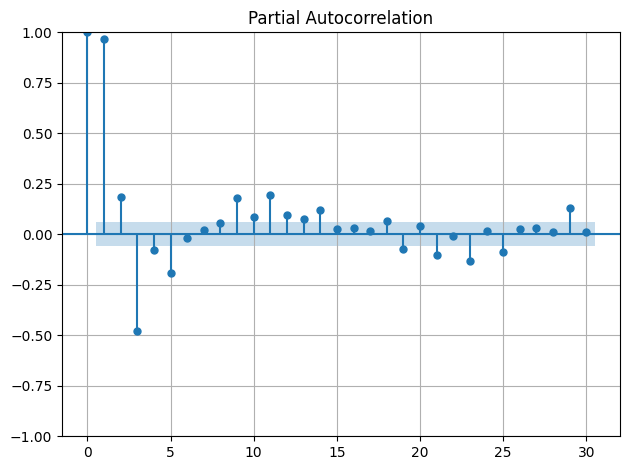

In [ ]:
# PACF plot

plot_pacf(df['pressure'], lags=30);
plt.grid(True)
plt.tight_layout()
plt.show()

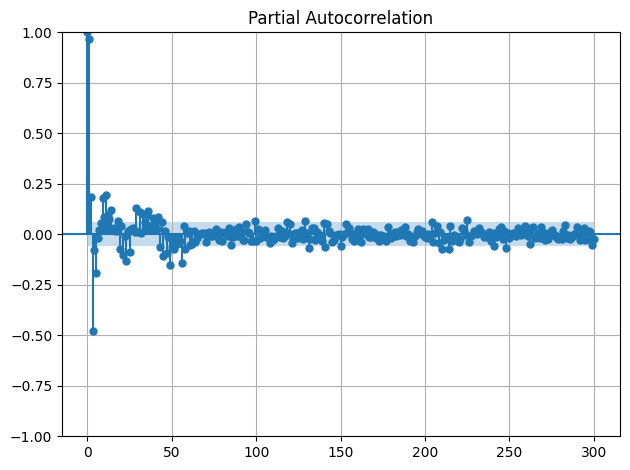

In [ ]:
# PACF plot

plot_pacf(df['pressure'], lags=300);
plt.grid(True)
plt.tight_layout()
plt.show()

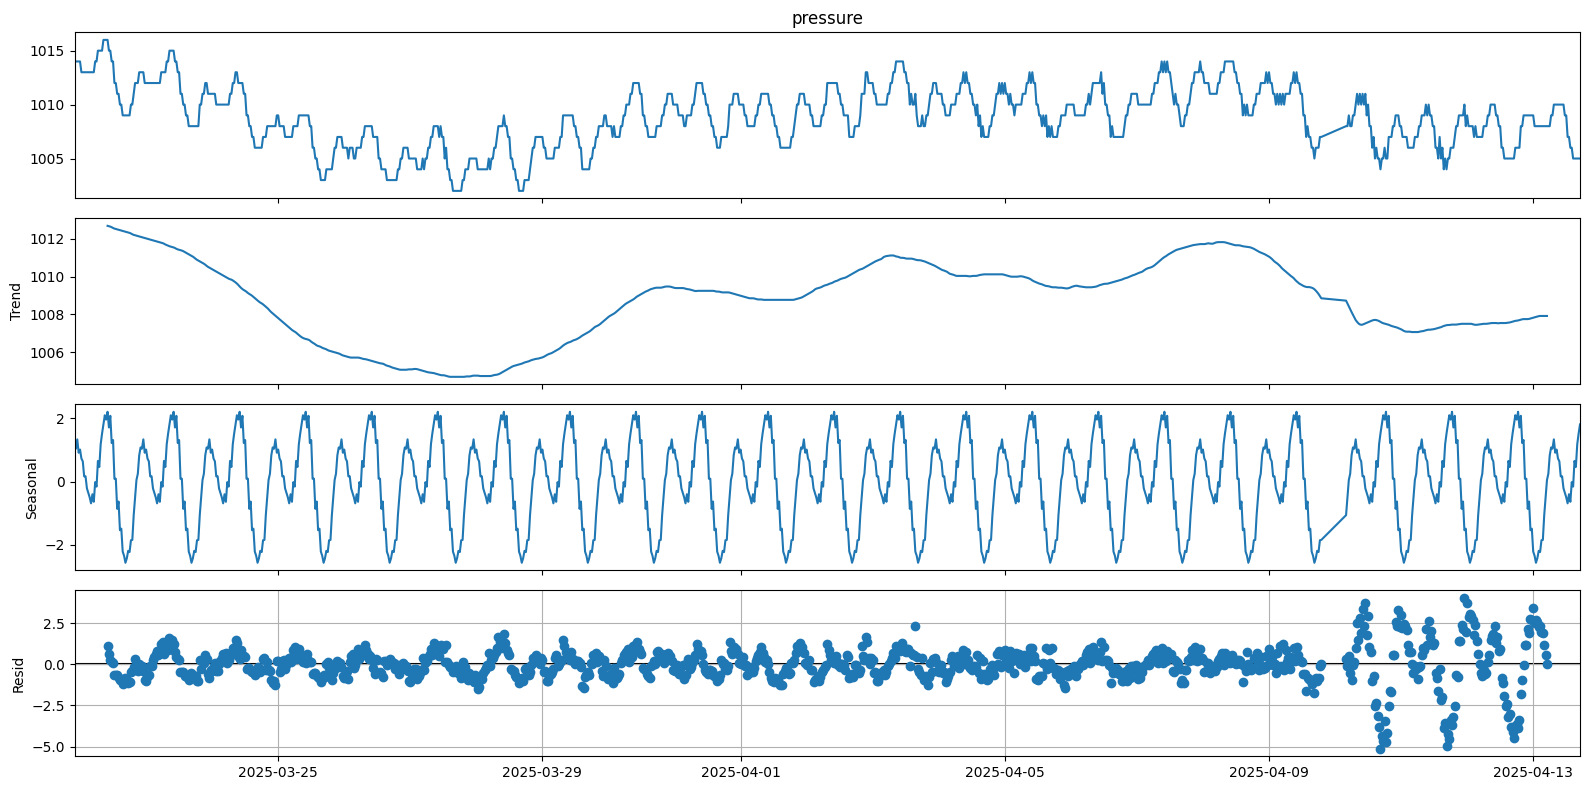

In [ ]:
df['ts'] = pd.to_datetime(df['ts'])
result = seasonal_decompose(df.set_index('ts')['pressure'], model='additive', period=48)
fig = result.plot()
fig.set_size_inches(16, 8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Model creation

From the PACF and ACF plots, the lags suggest that this is a ARMA(2,2) model

seasonal decomposition suggests the seasonal component is (2, 0, 2, 24)

## Split train-testing data

We split the data into training and testing in order to avoid data leakage.

In [19]:
df_train = df[(df['ts'] <= '2025-04-05 19:00:00')]
df_test= df[(df['ts'] <= '2025-04-09 19:00:00') & (df['ts'] > '2025-04-05 19:00:00')]

# Example of SARIMA | SARIMAX models

## Auto ARIMA (Humidity)

Auto-ARIMA is a brute force algoritim to find the "best fit" for the ARIMA order.

Below is a basic implementation of Auto-ARIMA to find the p, q parameters, assuming the Intergrated order is 0 using AIC as the criterion.

In [ ]:
# check hypothesis with AIC as criteeria
import itertools
p = q = range(0, 4)
pq = itertools.product(p, q)
aic = []
for param in pq:
    try:
        mod = ARIMA(df_test['humidity'],order=(param[0], 0, param[1]))
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        aic.append((param, results.aic))
    except:
        continue

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

ARIMA(0, 0) - AIC:1510.7751213432248
ARIMA(0, 1) - AIC:1354.121024494237


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(0, 2) - AIC:1280.3332083341297


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(0, 3) - AIC:1246.1198618414905
ARIMA(1, 0) - AIC:1148.2213359308075


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

ARIMA(1, 1) - AIC:1145.4911006786515


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(1, 2) - AIC:1147.0344669317096


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(1, 3) - AIC:1140.5657904713594


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(2, 0) - AIC:1145.4779066756362


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(2, 1) - AIC:1147.3583479519473


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(2, 2) - AIC:1121.1905180130016


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(2, 3) - AIC:1122.4901325794099


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(3, 0) - AIC:1147.0813198383075


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(3, 1) - AIC:1148.4732129159067


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(3, 2) - AIC:1122.7714099293048


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(3, 3) - AIC:1123.8429781678483


In [ ]:
best_pq = min(aic, key= lambda x: x[1])
print(f'The best parameters for pq are {best_pq[0]}')

The best parameters for pq are (2, 2)


## SARIMA (Temperature)

In [ ]:
# train the model
arima = SARIMAX(df_train.set_index('ts')['temperature'], order=(2,0,2), seasonal_order=(2,0,2,24))
trained_model = arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# predict testing data
predictions = trained_model.forecast(steps=len(df_test))

<ipython-input-20-e2990f7274d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ts'] = pd.to_datetime(df_test['ts'])


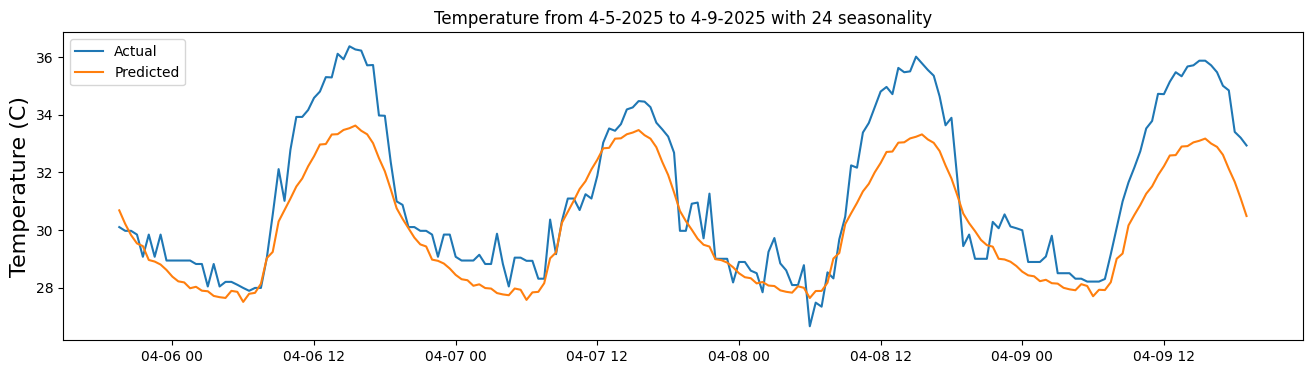

In [ ]:
plt.figure(figsize=(16,4))
df_test['ts'] = pd.to_datetime(df_test['ts'])
plt.plot(df_test.set_index('ts')['temperature'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Temperature from 4-5-2025 to 4-9-2025 with 24 seasonality')
plt.ylabel('Temperature (C)', fontsize=16)
plt.legend()

### model evaluation

In [ ]:
print(f"Mean Absolute Error: {MAE(df_test['temperature'], predictions)}")
print(f"Root Mean Squared Error: {RMSE(df_test['temperature'], predictions)}")

Mean Absolute Error: 1.1453445261612412
Root Mean Squared Error: 1.424007121582283


## SARMIA (Humidity)

In [ ]:
# train the model
arima = SARIMAX(df_train.set_index('ts')['humidity'], order=(2,0,2), seasonal_order=(2,0,2,24))
trained_model = arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# summary
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           humidity   No. Observations:                  715
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood               -2111.034
Date:                            Sat, 19 Apr 2025   AIC                           4240.068
Time:                                    07:02:41   BIC                           4281.218
Sample:                                03-21-2025   HQIC                          4255.959
                                     - 04-05-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0323      0.022      1.472      0.141      -0.011       0.075
ar.L2          0.9676      0.022     44.125      0.000       0.925       1.011
ma.L1          0.5776      0.037     15.446      0.000       0.504       0.651
ma.L2         -0.3164      0.033     -9.486      0.000      -0.382      -0.251
ar.S.L24      -0.0311      0.090     -0.346      0.729      -0.207       0.145
ar.S.L48       0.9410      0.090     10.441      0.000       0.764       1.118
ma.S.L24      -0.0283      0.110     -0.259      0.796      -0.243       0.186
ma.S.L48      -0.8396      0.105     -8.024      0.000      -1.045      -0.635
sigma2        20.5980      0.857     24.042      0.000      18.919      22.277
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                93.57
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.20
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# predict testing data
predictions = trained_model.forecast(steps=len(df_test))

<ipython-input-25-1a515cadc870>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ts'] = pd.to_datetime(df_test['ts'])


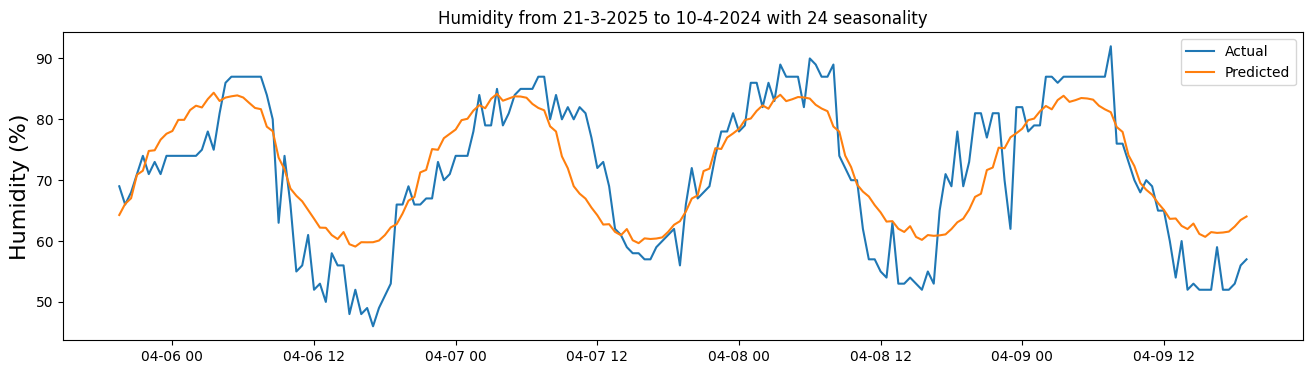

In [ ]:
plt.figure(figsize=(16,4))
df_test['ts'] = pd.to_datetime(df_test['ts'])
plt.plot(df_test.set_index('ts')['humidity'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Humidity from 21-3-2025 to 10-4-2024 with 24 seasonality')
plt.ylabel('Humidity (%)', fontsize=16)
plt.legend()

### model evaluation

In [ ]:
print(f"Mean Absolute Error: {MAE(df_test['humidity'], predictions)}")
print(f"Root Mean Squared Error: {RMSE(df_test['humidity'], predictions)}")

Mean Absolute Error: 5.258855750339234
Root Mean Squared Error: 6.395624507396503


## SARMIA (pressure)

In [ ]:
# check hypothesis with AIC as criteeria
import itertools
p = q = range(0, 4)
pq = itertools.product(p, q)
aic = []
for param in pq:
    try:
        mod = SARIMAX(df_train.set_index('ts')['pressure'],order=(param[0], 0, param[1]), seasonal_order=(param[0], 0, param[1], 24))
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        aic.append((param, results.aic))
    except:
        continue

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

ARIMA(0, 0) - AIC:11921.50508865103
ARIMA(0, 1) - AIC:10055.91330482152


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA(0, 2) - AIC:8337.841591267135


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimizat

ARIMA(0, 3) - AIC:7038.423883265221


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min 

ARIMA(1, 0) - AIC:1780.347407821035
ARIMA(1, 1) - AIC:1206.0952740018793


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(1, 2) - AIC:1055.8418404512713


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 3) - AIC:1046.8187463625045


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting

ARIMA(2, 1) - AIC:1426.84297297828


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(2, 2) - AIC:18.0


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 3) - AIC:963.4332435053183


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  

ARIMA(3, 2) - AIC:984.477965131269


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 3) - AIC:959.347612312696


In [ ]:
best_pq = min(aic, key= lambda x: x[1])
print(f'The best parameters for pq are {best_pq[0]}')

The best parameters for pq are (2, 2)


In [ ]:
# train the model
arima = SARIMAX(df_train.set_index('ts')['pressure'],exog= order=(2,0,2), seasonal_order=(2,0,2,24), enforce_stationarity=False)
trained_model = arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# summary
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           pressure   No. Observations:                  715
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood                -423.869
Date:                            Sat, 19 Apr 2025   AIC                            865.737
Time:                                    08:50:21   BIC                            906.222
Sample:                                03-21-2025   HQIC                           881.425
                                     - 04-05-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7332      0.287      2.556      0.011       0.171       1.296
ar.L2          0.2564      0.284      0.902      0.367      -0.301       0.814
ma.L1         -0.1920      0.277     -0.694      0.488      -0.734       0.350
ma.L2         -0.2316      0.135     -1.720      0.085      -0.495       0.032
ar.S.L24       0.0786      0.019      4.148      0.000       0.041       0.116
ar.S.L48       0.9216      0.019     48.599      0.000       0.884       0.959
ma.S.L24      -0.0795      0.050     -1.603      0.109      -0.177       0.018
ma.S.L48      -0.5833      0.042    -13.832      0.000      -0.666      -0.501
sigma2         0.1987      0.010     20.635      0.000       0.180       0.218
===================================================================================
Ljung-Box (L1) (Q):                   3.52   Jarque-Bera (JB):                32.33
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# predict testing data
predictions = trained_model.forecast(steps=len(df_test))

In [ ]:
predictions

,predicted_mean
2025-04-05 19:30:00,1008.254870
2025-04-05 20:00:00,1008.765334
2025-04-05 20:30:00,1009.478239
2025-04-05 21:00:00,1010.064826
2025-04-05 21:30:00,1010.453097
...,...
2025-04-09 17:00:00,1007.914144
2025-04-09 17:30:00,1007.859610
2025-04-09 18:00:00,1007.970266
2025-04-09 18:30:00,1008.378268


<ipython-input-141-8adb2e52d528>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ts'] = pd.to_datetime(df_test['ts'])


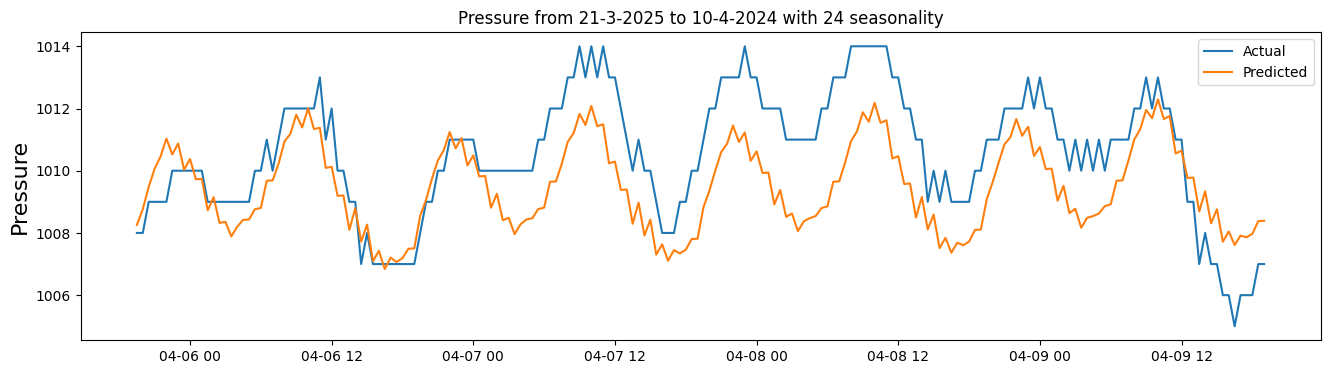

In [ ]:
plt.figure(figsize=(16,4))
df_test['ts'] = pd.to_datetime(df_test['ts'])
plt.plot(df_test.set_index('ts')['pressure'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Pressure from 21-3-2025 to 10-4-2024 with 24 seasonality')
plt.ylabel('Pressure', fontsize=16)
plt.legend()

### model evaluation

In [ ]:
print(f"Mean Absolute Error: {MAE(df_test['pressure'], predictions)}")
print(f"Root Mean Squared Error: {RMSE(df_test['pressure'], predictions)}")

Mean Absolute Error: 1.4434132931774233
Root Mean Squared Error: 1.6766913572493263


## ARIMAX model (Humidity)



In [ ]:
df_train

,ts,location,wind_sp,wind_deg,pressure,temperature,humidity,cloud_per,rain_amt,weather
0,2025-03-21 22:00:00,Kasetsart University,2.57,3,1014,27.67,46,20,0.0,few clouds
1,2025-03-21 22:30:00,Kasetsart University,4.12,4,1014,29.32,47,20,0.0,few clouds
2,2025-03-21 23:00:00,Kasetsart University,4.12,4,1014,28.33,48,20,0.0,few clouds
3,2025-03-21 23:30:00,Kasetsart University,3.60,4,1014,27.85,50,20,0.0,few clouds
4,2025-03-22 00:00:00,Kasetsart University,4.12,4,1014,27.38,52,20,0.0,few clouds
...,...,...,...,...,...,...,...,...,...,...
1264,2025-04-05 17:00:00,Kasetsart University,5.66,6,1008,35.18,52,20,0.0,few clouds
1265,2025-04-05 17:30:00,Kasetsart University,5.66,6,1007,34.55,58,20,0.0,few clouds
1266,2025-04-05 18:00:00,Kasetsart University,5.66,6,1007,33.33,60,20,0.0,few clouds
1267,2025-04-05 18:30:00,Kasetsart University,5.66,6,1007,32.06,60,20,0.0,few clouds


In [ ]:
df_test

,ts,location,wind_sp,wind_deg,pressure,temperature,humidity,cloud_per,rain_amt,weather
1269,2025-04-05 19:30:00,Kasetsart University,4.12,4,1008,30.10,69,20,0.0,few clouds
1270,2025-04-05 20:00:00,Kasetsart University,4.12,4,1008,29.97,66,20,0.0,few clouds
1271,2025-04-05 20:30:00,Kasetsart University,4.63,5,1009,29.97,68,20,0.0,few clouds
1272,2025-04-05 21:00:00,Kasetsart University,4.12,4,1009,29.84,71,20,0.0,few clouds
1273,2025-04-05 21:30:00,Kasetsart University,5.14,5,1009,29.07,74,20,0.0,few clouds
...,...,...,...,...,...,...,...,...,...,...
1579,2025-04-09 17:00:00,Kasetsart University,4.63,5,1006,35.00,52,20,0.0,few clouds
1581,2025-04-09 17:30:00,Kasetsart University,4.63,5,1006,34.84,52,20,0.0,few clouds
1583,2025-04-09 18:00:00,Kasetsart University,5.14,5,1006,33.40,53,20,0.0,few clouds
1585,2025-04-09 18:30:00,Kasetsart University,5.66,6,1007,33.20,56,20,0.0,few clouds


In [ ]:
# train the model
arima = SARIMAX(df_train.set_index('ts')['humidity'],df_train.set_index('ts')[['temperature', 'pressure']], order=(2,0,0), seasonal_order=(0,0,0,0))
trained_model = arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


In [ ]:
# summary
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               humidity   No. Observations:                  715
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -2038.522
Date:                Sat, 19 Apr 2025   AIC                           4087.044
Time:                        07:02:42   BIC                           4109.905
Sample:                    03-21-2025   HQIC                          4095.872
                         - 04-05-2025                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -2.9985      0.147    -20.423      0.000      -3.286      -2.711
pressure        0.1562      0.005     32.011      0.000       0.147       0.166
ar.L1           0.5685      0.029     19.423      0.000       0.511       0.626
ar.L2           0.3668      0.030     12.334      0.000       0.308       0.425
sigma2         17.4904      0.688     25.424      0.000      16.142      18.839
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               131.47
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.35
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# predict testing data
predictions = trained_model.forecast(steps=len(df_test), exog=df_test.set_index('ts')[['temperature', 'pressure']])

In [ ]:
predictions

,predicted_mean
2025-04-05 19:30:00,65.783777
2025-04-05 20:00:00,66.146407
2025-04-05 20:30:00,66.404054
2025-04-05 21:00:00,66.841576
2025-04-05 21:30:00,69.214747
...,...
2025-04-09 17:00:00,52.165142
2025-04-09 17:30:00,52.644906
2025-04-09 18:00:00,56.962716
2025-04-09 18:30:00,57.718593


In [ ]:
df_test.set_index('ts')['humidity']

,humidity
ts,
2025-04-05 19:30:00,69
2025-04-05 20:00:00,66
2025-04-05 20:30:00,68
2025-04-05 21:00:00,71
2025-04-05 21:30:00,74
...,...
2025-04-09 17:00:00,52
2025-04-09 17:30:00,52
2025-04-09 18:00:00,53


<ipython-input-34-2c91d58f94e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ts'] = pd.to_datetime(df_test['ts'])


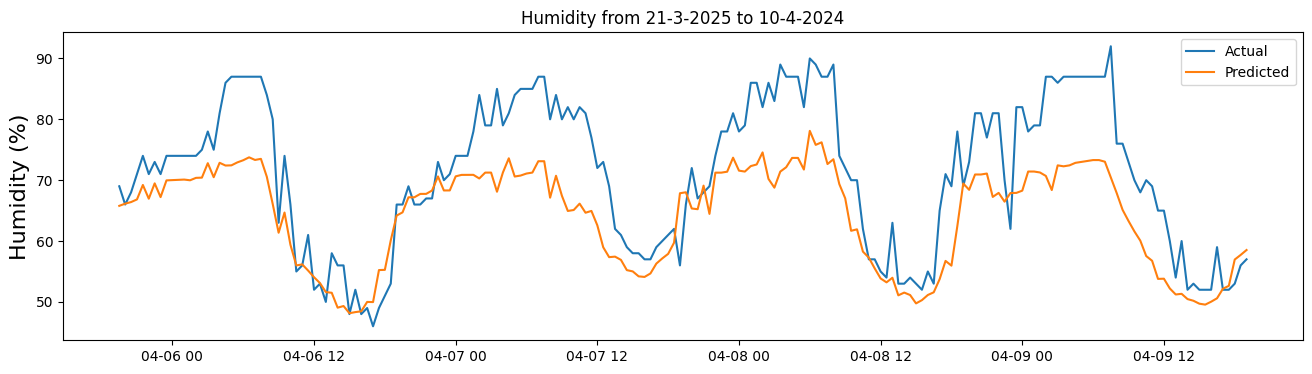

In [ ]:
plt.figure(figsize=(16,4))
df_test['ts'] = pd.to_datetime(df_test['ts'])
plt.plot(df_test.set_index('ts')['humidity'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Humidity from 21-3-2025 to 10-4-2024')
plt.ylabel('Humidity (%)', fontsize=16)
plt.legend()

### ARIMAX model evaluation

In [ ]:
print(f"Mean Absolute Error: {MAE(df_test['humidity'], predictions)}")
print(f"Root Mean Squared Error: {RMSE(df_test['humidity'], predictions)}")

Mean Absolute Error: 7.5515935575675
Root Mean Squared Error: 9.19237133344426


## SARIMAX model

In [ ]:
# train the model
sarima = SARIMAX(df_train.set_index('ts')['humidity'],df_train.set_index('ts')[['temperature', 'pressure']], order=(2,0,2), seasonal_order=(2,0,2,24))
trained_model = sarima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# summary
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           humidity   No. Observations:                  715
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood               -2020.758
Date:                            Sat, 19 Apr 2025   AIC                           4063.516
Time:                                    07:03:44   BIC                           4113.811
Sample:                                03-21-2025   HQIC                          4082.939
                                     - 04-05-2025                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -2.7669      0.161    -17.168      0.000      -3.083      -2.451
pressure        0.1485      0.006     26.198      0.000       0.137       0.160
ar.L1          -0.0145      0.018     -0.812      0.417      -0.049       0.020
ar.L2           0.9447      0.017     56.078      0.000       0.912       0.978
ma.L1           0.5943      0.036     16.596      0.000       0.524       0.664
ma.L2          -0.3203      0.033     -9.852      0.000      -0.384      -0.257
ar.S.L24       -0.0099      0.097     -0.102      0.919      -0.200       0.180
ar.S.L48        0.8657      0.107      8.063      0.000       0.655       1.076
ma.S.L24       -0.0162      0.116     -0.139      0.890      -0.244       0.212
ma.S.L48       -0.7752      0.128     -6.043      0.000      -1.027      -0.524
sigma2         16.5882      0.671     24.734      0.000      15.274      17.903
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               154.52
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.37
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# predict testing data
predictions = trained_model.forecast(steps=len(df_test), exog=df_test.set_index('ts')[['temperature', 'pressure']])

<ipython-input-39-2c91d58f94e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ts'] = pd.to_datetime(df_test['ts'])


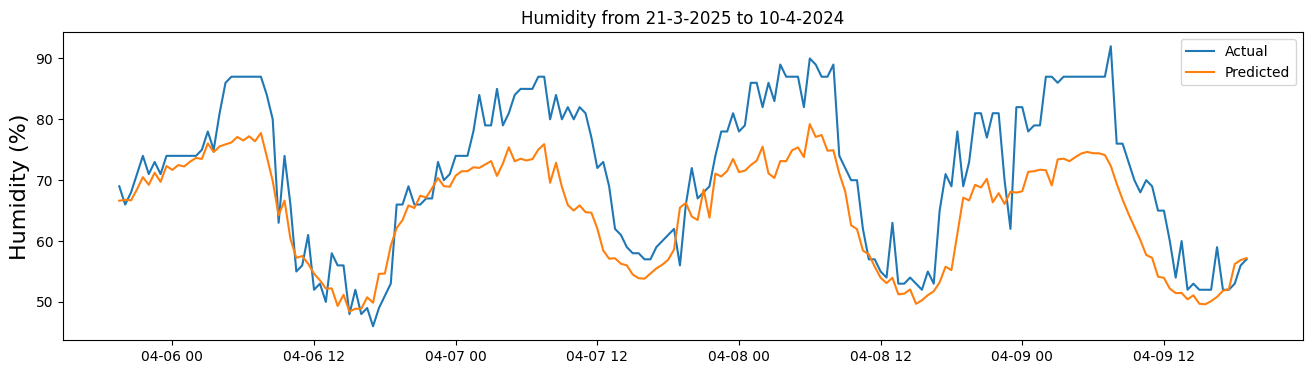

In [ ]:
plt.figure(figsize=(16,4))
df_test['ts'] = pd.to_datetime(df_test['ts'])
plt.plot(df_test.set_index('ts')['humidity'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Humidity from 21-3-2025 to 10-4-2024')
plt.ylabel('Humidity (%)', fontsize=16)
plt.legend()

### model evaluation

In [ ]:
print(f"Mean Absolute Error: {MAE(df_test['humidity'], predictions)}")
print(f"Root Mean Squared Error: {RMSE(df_test['humidity'], predictions)}")

Mean Absolute Error: 6.838753877273768
Root Mean Squared Error: 8.412508382449586


# Saving models trained in jupyter notebooks


To save a statsmodels model you can use the following method
```
yourmodel.save(filename:str, remove_data:bool)
```
Note the remove_data argument:
- By default this argument is False
- When saved if removed data is false the training data, along with the model's lags, and observation data is saved.
  - This enables all methods, but significantly increases file size (file in MB)
- When saved if removed data is True, the model will have to have its training data re-inserted when loaded.
  - This requires you to re-insert data before you can use the model
  - The up-side is that the model file size is significantly reduced (file in KB)


Saving:
```
# code example saving the model
arima = SARIMAX(df_train.set_index('ts')['temperature'], order=(2,0,2), seasonal_order=(2,0,2,24))
trained_model = arima.fit()
trained_model.save('ndat_temperature_SARIMA.pkl', remove_data=True)
```

Loading:
```
# loading a model saved with remove_data =False
saved_model = SARIMAXResults.load(model_dir)
# yes, it's that easy
```
```
# loading a model saved with remove_data =True

## get the model parameters
order = saved_model.model.order
seasonal_order = saved_model.model.seasonal_order
## load the training data
train_dataset = pd.read_csv(data_dir) <- your data
## load the model parameters
saved_model = SARIMAXResults.load(model_dir)

## set the model arguments
model = SARIMAX(
    train_dataset,
    order=order,
    seasonal_order=seasonal_order,
)
model = model.filter(saved_model.params)
```

To save a sklearn model

Save:
```
# saving a KNN classifier model

import pickle
neigh = KNeighborsClassifier(n_neighbors=2, metric="euclidean")
neigh = neigh.fit(X_train, y_train)

with open('rainKNN.pkl','wb') as f:
    pickle.dump(neigh,f)
```

Load:
```
classifier = pickle.load(open(model_dir, "rb"))
```


# Conclusion

From this guide, I hope you have learned how to construct an ARIMA|SARIMA|SARIMAX model.

Remember due to the nature of the models trending to the mean, they generally get worse in accuracy the further you predict into the future. In order to improve/preserve accuracy you can use the following techiniques.

- using statmodels.append(obs, refit=False) to add real observed data after the last observation in the model's trained data to help prediction accuracy
  - Note that this will make the model start predictions at the end of the new observations

- load training data based on new data (in the case of models saved with remove_data = True)

- Training the data on a larger frequency, example: daily average in a month, montly average over a year.